In [18]:
from load_data import * 
from helpers import mtanh, calculate_pressure, normal_distribution, calculate_bohmgyrbohm_particlediffusion, TransParams, solve_pde, T_model, n_model, get_chi_inter, get_d_inter,get_chi_inter_unscaled, get_d_inter_unscaled, get_chi_inter_ped, get_d_inter_ped, BCS, solve_time_evolution, calculate_bohmgrybohm_from_jardin, calculate_bohmdiffusion
from helpers import setup_domain, setup_intra_params, setup_inter_params, get_c_inter_over_time, single_c_growth_run_from_postelm_crash, unended_c_growth_run_from_postelm_crash, calculate_maxalpha
import matplotlib.pyplot as plt 
import scienceplots 
import os 
import sys 
plt.style.use(['science', 'grid'])

from scipy.integrate import simpson
from scipy.signal import find_peaks

from tqdm.notebook import tqdm 
FIGURE_DIR = '/home/akadam/EUROfusion/2024/pedestal_transport/models/data_driven/figures'

In [2]:
BASE_PULSE_DIR = "/home/akadam/EUROfusion/2024/data"
shot_num = 83624
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")
JET_PDB_DIR = "/home/akadam/EUROfusion/2024/data"

pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)

N_POINTS    = 1000
R           = np.linspace(machineparams.Rmaj, machineparams.Rmaj + machineparams.Rmin, N_POINTS)
phi         = R**2
phi_norm    = (phi - phi.min()) / (phi.max() - phi.min())
pedestal_region =  phi_norm > 0.65
phi_norm    = phi_norm[pedestal_region]
phi         = phi[pedestal_region]
R           = R[pedestal_region]
dphi_normdr = 2*R / (phi.max() - phi.min())

xdomain = setup_domain(machineparams)

steady_state_te = mtanh(phi_norm, te_fit_params.h1, te_fit_params.h0, te_fit_params.s, te_fit_params.w, te_fit_params.p)
steady_state_ne = mtanh(phi_norm, ne_fit_params.h1, ne_fit_params.h0, ne_fit_params.s, ne_fit_params.w, ne_fit_params.p)
steady_state_pe = mtanh(phi_norm, pe_fit_params.h1, pe_fit_params.h0, pe_fit_params.s, pe_fit_params.w, pe_fit_params.p)
steady_state_pe = calculate_pressure(steady_state_te, steady_state_ne)

ne_fit_params.steady_state_arr = steady_state_ne
te_fit_params.steady_state_arr = steady_state_te
pe_fit_params.steady_state_arr = steady_state_pe

# print(te_fit_params.h1, ne_fit_params.h1, pe_fit_params.h1)

# Finding ELM timings 
normed_tbeo = (pulse.tbeo.data - pulse.tbeo.data.mean() ) / pulse.tbeo.data.std()
delta_t = pulse.tbeo.time[1] - pulse.tbeo.time[0]
distance_between_elms = int(200E-6 / delta_t)*20
threshold_height = normed_tbeo.std()*2
peaks, _ = find_peaks(normed_tbeo, height=threshold_height, distance=distance_between_elms)
adjusted_peaks = np.empty_like(peaks)
# TODO: SHIFT THE TBEO SIGNAL BY SOME TIME 
for i, pk in enumerate(peaks): 
    for k in range(30): 
        if normed_tbeo[pk - k] < 0: 
            zero_crossing = pk-k 
            break 
        else: 
            zero_crossing = pk 
    adjusted_peaks[i] = zero_crossing


elm_times = pulse.tbeo.time[peaks]

elm_frequency = len(peaks) / (pulse.tbeo.time[-1] - pulse.tbeo.time[0])
t_minus_t_elm = np.empty(len(relevant_profiles.hrts_times))
for i, t in enumerate(relevant_profiles.hrts_times):
    nearest_elm_idx = np.argmin(np.abs(elm_times - t))
    t_nearest_elm = elm_times[nearest_elm_idx]    
    t_minus_t_elm[i] = t - t_nearest_elm
print(elm_frequency)


35.85133601682542


In [3]:
chi_gb, gyroradius = calculate_bohmgrybohm_from_jardin(R, phi, phi_norm, steady_state_te, machineparams)
Dbohm = calculate_bohmdiffusion(steady_state_te, machineparams)
Dbohmgb = calculate_bohmgyrbohm_particlediffusion(steady_state_te, machineparams)

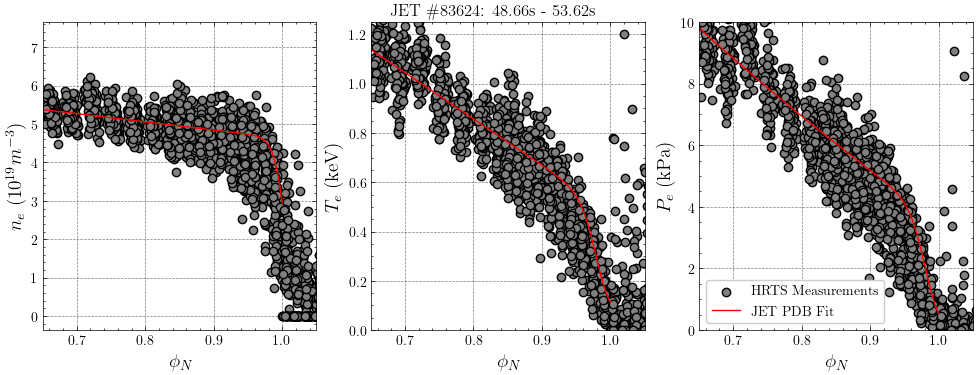

In [4]:

""" Plotting of crash """
if shot_num == 83624:
    offset = 0.046
elif shot_num == 83625:
    offset = 0.041
elif shot_num == 83627:
    offset = 0.043
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83630: 
    offset = 0.045
elif shot_num == 83631:
    offset = 0.0384
elif shot_num == 83633:
    offset = 0.04
elif shot_num == 83637:
    offset = 0.048
elif shot_num == 83640:
    offset = 0.048
else: 
    offset = 0.0

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()

axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[0].plot(phi_norm, steady_state_ne, color='red')

axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[1].plot(phi_norm, steady_state_te, color='red')

axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'HRTS Measurements')
axs[2].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

axs[0].set_xlim(0.0, 7.5)
axs[1].set_ylim(0.0, 1.25)
axs[2].set_ylim(0, 10)
axs[0].set_ylabel(r'$n_e$ ($10^{19} m^{-3}$)', fontsize=14)
axs[1].set_ylabel(r'$T_e$ (keV)', fontsize=14)
axs[2].set_ylabel(r'$P_e$ (kPa)', fontsize=14)

for ax in axs: 
    ax.set_xlim(phi_norm.min(), 1.05)
    ax.set_xlabel(r'$\phi_N$', fontsize=14)

# axs[4].set_ylim(0.0, 40)
# axs[4].plot(phi_norm, chi_gb, color='red')
# axs[4].set_title(r'$\chi_{GB}$')
# axs[4].set_ylabel(r'$m^2 / s$')
# axs[3].set_ylabel(r'$m^2 / s$')
# axs[3].plot(phi_norm, Dbohm, color='red')
# # axs[3].plot(phi_norm, Dbohmgb, color='blue')
# axs[3].set_title(r'$D_{Bohm}$')
# axs[5].remove()
axs[2].legend()
# fig.suptitle(r'$\phi = (r^2 - R_{maj}) / (R_{maj} + R_{min})^2$', y=0.925)
fig.suptitle(f'JET \#{shot_num}: {pulse.t1:.4}s - {pulse.t2:.4}s', y=0.925)
fname = os.path.join(FIGURE_DIR, f'jet_{shot_num}_profiles.png')
plt.savefig(fname, dpi=300, transparent=True)
plt.show()

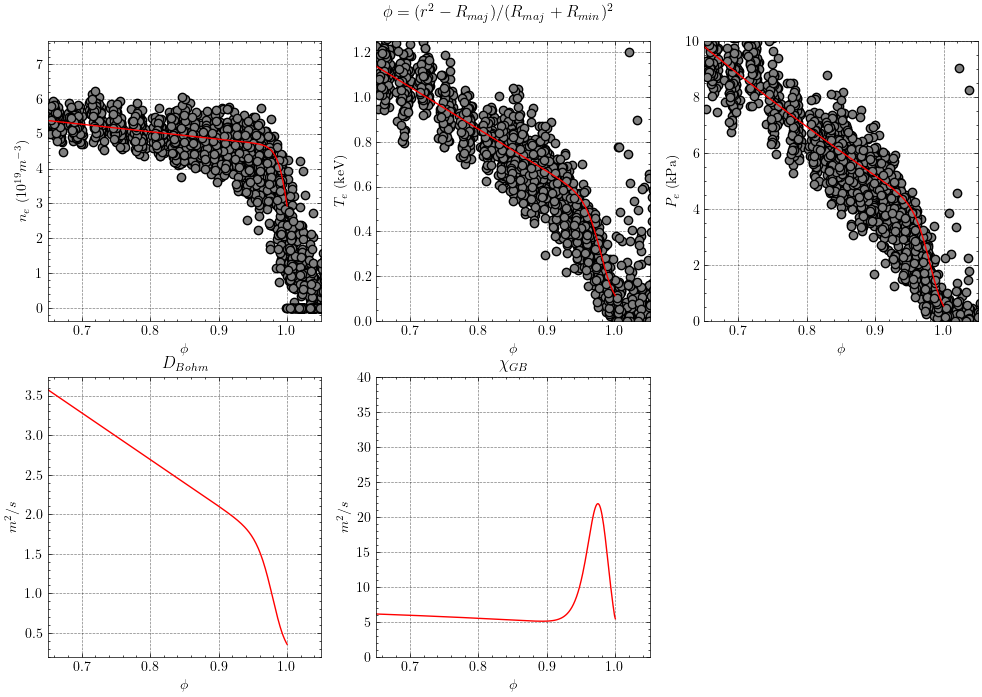

In [6]:

""" Plotting of crash """
if shot_num == 83624:
    offset = 0.046
elif shot_num == 83625:
    offset = 0.041
elif shot_num == 83627:
    offset = 0.043
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83630: 
    offset = 0.045
elif shot_num == 83631:
    offset = 0.0384
elif shot_num == 83633:
    offset = 0.04
elif shot_num == 83637:
    offset = 0.048
elif shot_num == 83640:
    offset = 0.048
else: 
    offset = 0.0

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[0].plot(phi_norm, steady_state_ne, color='red')

axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[1].plot(phi_norm, steady_state_te, color='red')

axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[2].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

axs[0].set_xlim(0.0, 7.5)
axs[1].set_ylim(0.0, 1.25)
axs[2].set_ylim(0, 10)
axs[0].set_ylabel(r'$n_e$ ($10^{19} m^{-3}$)')
axs[1].set_ylabel(r'$T_e$ (keV)')
axs[2].set_ylabel(r'$P_e$ (kPa)')

for ax in axs: 
    ax.set_xlim(phi_norm.min(), 1.05)
    ax.set_xlabel(r'$\phi$')

axs[4].set_ylim(0.0, 40)
axs[4].plot(phi_norm, chi_gb, color='red')
axs[4].set_title(r'$\chi_{GB}$')
axs[4].set_ylabel(r'$m^2 / s$')
axs[3].set_ylabel(r'$m^2 / s$')
axs[3].plot(phi_norm, Dbohm, color='red')
# axs[3].plot(phi_norm, Dbohmgb, color='blue')
axs[3].set_title(r'$D_{Bohm}$')
axs[5].remove()

fig.suptitle(r'$\phi = (r^2 - R_{maj}) / (R_{maj} + R_{min})^2$', y=0.925)
plt.show()

In [19]:
C_CRASH    = 2.5
CHI0_INTRA = chi_gb[0]
D0_INTRA   = Dbohm[0]

intra_params = TransParams(
    CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w, C_CRASH, CHI0_INTRA), # np.ones_like(phi_norm),
    D=normal_distribution(phi_norm, ne_fit_params.p, ne_fit_params.w / 2.0, C_CRASH, D0_INTRA), # np.ones_like(phi_norm),
    V=np.ones_like(phi_norm),
    S_N=np.zeros_like(phi_norm),
    S_T=np.zeros_like(phi_norm),
    _C = C_CRASH,
    ne_fitparams=ne_fit_params, 
    te_fitparams=te_fit_params, 
    bcs=BCS.INTRA_FLUXIN, 
    dphi_normdr=dphi_normdr
)

# NB this should be a gradient with respect to R? or not I think it is fine actually for this case 
# intra_params.heatfluxin = phi_norm[0]*(CHI0_INTRA*5.0)*np.gradient(steady_state_te, phi_norm)[0]
intra_params.heatfluxin   = phi_norm[0]*(chi_gb[0])*np.gradient(steady_state_te, phi_norm)[0]
intra_params.te_inner_lim = 0.9*max(steady_state_te)

intra_params.particlefluxin = phi_norm[0]*(D0_INTRA*01000.0)*np.gradient(steady_state_ne, phi_norm)[0] + intra_params.V[0]*steady_state_ne[0]
intra_params.particlefluxout = phi_norm[0]*(D0_INTRA*10000.0)*np.gradient(steady_state_ne, phi_norm)[0] + intra_params.V[0]*steady_state_ne[0]

intra_params.ne_inner_lim = 0.9*max(steady_state_ne)
intra_params.ne_outer_lim = ne_fit_params.h1 * 0.5 # steady_state_ne[-1]*0.3

tau_intraelm = 200E-6 # 200 us
t_interval = [0, tau_intraelm]
t_keep     = np.linspace(0, tau_intraelm, 10)

solutions_intraelm_te = solve_pde(phi_norm, steady_state_te, t_interval, intra_params, T_model, t_keep)
solutions_intraelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, intra_params, n_model, t_keep)

post_elm_te = solutions_intraelm_te[:, -1]
post_elm_ne = solutions_intraelm_ne[:, -1]

C_INTER = 1.0
INTER_PARAMS = TransParams(
        CHI = np.empty_like(phi_norm),
        D   = np.empty_like(phi_norm),
        V   = phi_norm**5,
        S_N = np.zeros_like(phi_norm),
        S_T = np.zeros_like(phi_norm),
        _C  = C_INTER, 
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params,
        bcs=BCS.INTER_FLUXIN, 
        dphi_normdr=dphi_normdr
    )

INTER_PARAMS.CHI = get_chi_inter(phi_norm, CHI0_INTRA/C_INTER, steady_state_te, INTER_PARAMS)
INTER_PARAMS.D   = get_d_inter(phi_norm, D0_INTRA/C_INTER, steady_state_ne, INTER_PARAMS)

INTER_PARAMS.heatfluxin = phi_norm[0]*INTER_PARAMS.CHI[0]*np.gradient(steady_state_te, phi_norm)[0]
INTER_PARAMS.te_inner_lim = np.max(steady_state_te)

INTER_PARAMS.particlefluxin = phi_norm[0]*INTER_PARAMS.D[0]*np.gradient(steady_state_ne, phi_norm)[0] + INTER_PARAMS.V[0]*steady_state_ne[0]
INTER_PARAMS.particlefluxout = phi_norm[0]*INTER_PARAMS.D[0]*np.gradient(steady_state_ne, phi_norm)[0] + INTER_PARAMS.V[0]*steady_state_ne[0]
INTER_PARAMS.ne_inner_lim = np.max(steady_state_ne)
INTER_PARAMS.ne_outer_lim = steady_state_ne[-1]

tau_interelm = 0.04 # 
t_interval = [0, tau_interelm]
t_keep    = np.linspace(0, tau_interelm, 100)
solutions_interelm_te = solve_pde(phi_norm, post_elm_te, t_interval, INTER_PARAMS, T_model, t_keep)
solutions_interelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, INTER_PARAMS, n_model, t_keep)


AttributeError: 'NoneType' object has no attribute 'Rmaj'

  0%|          | 0/30 [00:00<?, ?it/s]

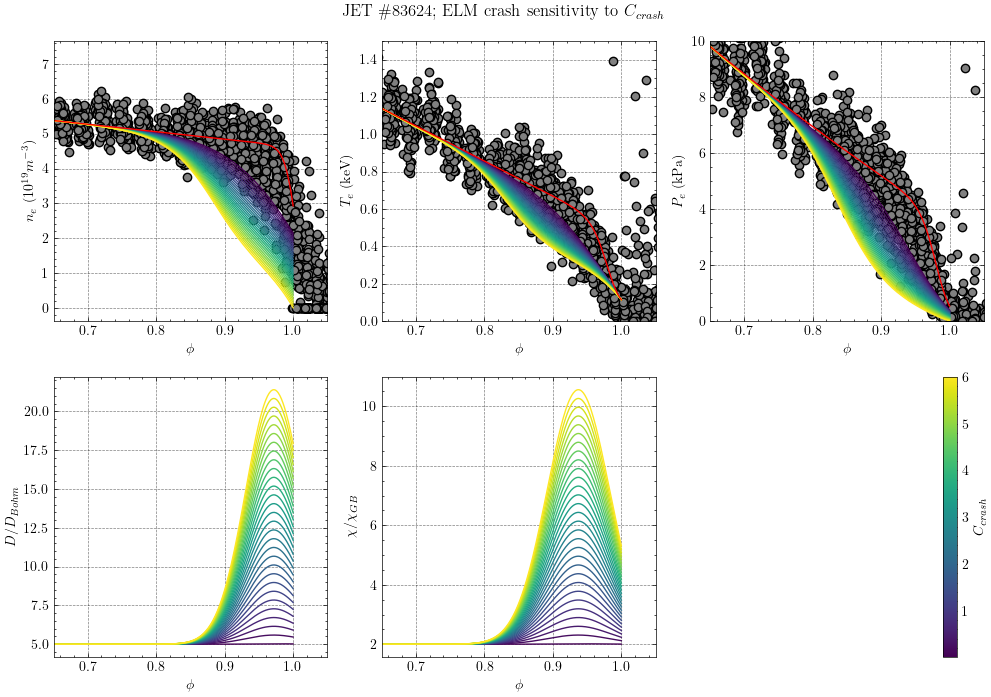

In [6]:
CHI0_INTRA = chi_gb[0]*2.0
D0_INTRA   = Dbohm[0]*5.0
tau_intraelm = 200E-6 # 200 us
t_interval = [0, tau_intraelm]
t_keep     = np.linspace(0, tau_intraelm, 10)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()
max_c_crash = 6.0
min_c_crash = 0.01
collected = []
scan_crashes = np.linspace(min_c_crash, max_c_crash, 30)
for C_CRASH in tqdm(scan_crashes): 
    intra_params = TransParams(
        CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.0, C_CRASH, CHI0_INTRA), # np.ones_like(phi_norm),
        D=normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.25, C_CRASH , D0_INTRA), # np.ones_like(phi_norm),
        V=np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_CRASH,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INTRA_FIXED, 
        dphi_normdr=dphi_normdr
    )

    # intra_params.heatfluxin = phi_norm[0]*(intra_params.CHI[0]*C_CRASH*10)*np.gradient(steady_state_te, phi_norm)[0]
    intra_params.heatfluxin   = phi_norm[0]*(chi_gb[0])*np.gradient(steady_state_te, phi_norm)[0]
    scale_factor = 0. # 0.6 + (1.0 - 0.8) * (1.0 - C_CRASH / max_c_crash)
    intra_params.te_inner_lim = 0.0 # scale_factor*max(steady_state_te)

    # intra_params.particlefluxin = (15*C_CRASH*intra_params.D[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
    intra_params.particlefluxin = (Dbohm[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
    intra_params.particlefluxout = (intra_params.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1]
    
    # scale_factor = 0.1 + (1.0 - 0.1) * (1.0 - C_CRASH / max_c_crash)
    intra_params.ne_inner_lim = 0.0 # max(steady_state_ne) * scale_factor # scale_factor # (1.0/(C_CRASH*2))
    intra_params.ne_outer_lim = 0.0 # steady_state_ne[-1] * scale_factor # (1.0/C_CRASH) # steady_state_ne[-1]*0.3
    solutions_intraelm_te = solve_pde(phi_norm, steady_state_te, t_interval, intra_params, T_model, t_keep)
    solutions_intraelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, intra_params, n_model, t_keep)

    # color = plt.cm.viridis((C_CRASH - 1.0) / 3.0)
    color = plt.cm.viridis((C_CRASH - min_c_crash) / (max_c_crash - min_c_crash))
    solutions_intraelm_pe = calculate_pressure(solutions_intraelm_te, solutions_intraelm_ne)

    collect = (C_CRASH, intra_params, solutions_intraelm_te, solutions_intraelm_ne, solutions_intraelm_pe)
    collected.append(collect)
    axs[0].plot(phi_norm, solutions_intraelm_ne[:, -1], color=color)
    axs[1].plot(phi_norm, solutions_intraelm_te[:, -1], color=color)
    axs[2].plot(phi_norm, solutions_intraelm_pe[:, -1], color=color)
    axs[3].plot(phi_norm, intra_params.D / Dbohm[0], color=color)
    axs[4].plot(phi_norm, intra_params.CHI / chi_gb[0], color=color)

axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[0].plot(phi_norm, steady_state_ne, color='red')

axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[1].plot(phi_norm, steady_state_te, color='red')


axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[2].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

axs[0].set_xlim(0.0, 7.5)
axs[1].set_ylim(0.0, 1.5)
axs[2].set_ylim(0, 10)
for ax in axs[:5]: 
    ax.set_xlim(np.min(phi_norm), 1.05)
    ax.set_xlabel(r'$\phi$')

axs[0].set_ylabel(r'$n_e$ ($10^{19} m^{-3}$)')
axs[1].set_ylabel(r'$T_e$ (keV)')
axs[2].set_ylabel(r'$P_e$ (kPa)')

axs[3].set_ylabel(r'$D / D_{Bohm}$')
axs[4].set_ylabel(r'$\chi / \chi_{GB}$')
fig.suptitle(f'JET \#{shot_num}; ELM crash sensitivity to $C_{{crash}}$', y=0.925)
axs[5].axis('off')
fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_crash, vmax=max_c_crash)), ax=axs[5], label=r'$C_{crash}$')
plt.show()


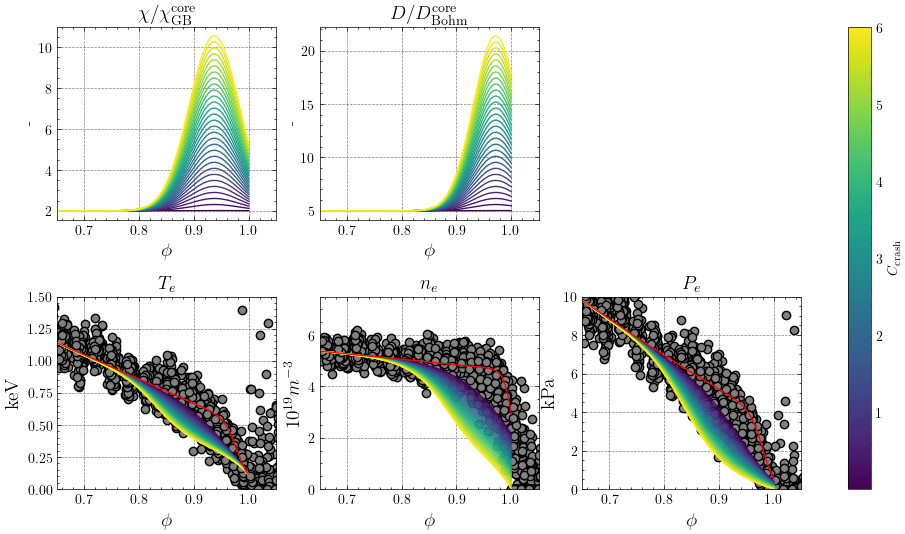

In [7]:
ped_idx_ne = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
ped_idx_te = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w)))

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.ravel()
# axs[0, 0] is Chi 
# axs[1, 0] is D
# axs[0, 1] is temperature 
# axs[1, 1] is density
# axs[0, 2] is pressure
for collect in collected: 
    C_CRASH, intra_params, solutions_intraelm_te, solutions_intraelm_ne, solutions_intraelm_pe = collect
    color = plt.cm.viridis((C_CRASH - min_c_crash) / (max_c_crash - min_c_crash))
    axs[3].plot(phi_norm, solutions_intraelm_te[:, -1], color=color)
    axs[4].plot(phi_norm, solutions_intraelm_ne[:, -1], color=color)
    axs[5].plot(phi_norm, solutions_intraelm_pe[:, -1], color=color)
    axs[1].plot(phi_norm, intra_params.D / Dbohm[0], color=color)
    axs[0].plot(phi_norm, intra_params.CHI / chi_gb[0], color=color)



axs[4].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[4].plot(phi_norm, steady_state_ne, color='red')

axs[3].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[3].plot(phi_norm, steady_state_te, color='red')

axs[5].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[5].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

for ax in axs: 
    ax.set_xlabel(r'$\phi$', fontsize=14)
    ax.set_xlim(np.min(phi_norm), 1.05)

axs[4].set_ylim(0.0, 7.5)
axs[5].set_ylim(0, 10)
axs[3].set_ylim(0.0, 1.5)

axs[3].set_title(r'$T_e$', fontsize=14)
axs[3].set_ylabel(r'keV', fontsize=14)
axs[4].set_title(r'$n_e$', fontsize=14)
axs[4].set_ylabel(r'$10^{19} m^{-3}$', fontsize=14)
axs[5].set_title(r'$P_e$', fontsize=14)
axs[5].set_ylabel(r'kPa', fontsize=14)
axs[1].set_title(r'$D / D_\text{Bohm}^\text{core}$', fontsize=14)
axs[0].set_title(r'$\chi / \chi_\text{GB}^\text{core}$', fontsize=14)
axs[0].set_ylabel(r'-')
axs[1].set_ylabel(r'-')

fig.subplots_adjust(hspace=0.4)
fig.colorbar(ax=axs, mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_crash, vmax=max_c_crash)), label=r'$C_\text{crash}$')

axs[2].remove()

fname = os.path.join(FIGURE_DIR, f'jet_{shot_num}_crash_sensitivity.png')
plt.savefig(fname, dpi=300, transparent=True)
plt.show()
 

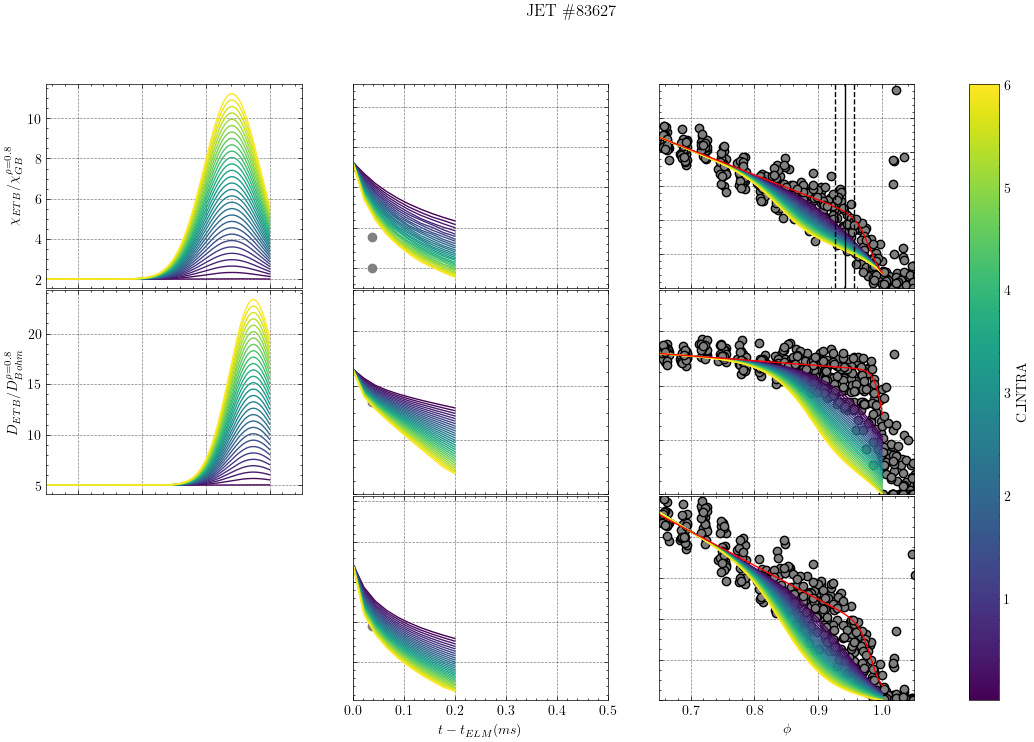

In [6]:

t_interest = 0.02
t_interest_idx = np.argmin(np.abs(t_keep - t_interest))
fig, axs = plt.subplots(3, 3, figsize=(14, 8), sharex='col')
axs = axs.ravel()
for collect in collected: 
    C_INTRA, INTRA_PARAMS, solutions_interelm_te, solutions_interelm_ne, solutions_intraelm_pe = collect

    stored_energy = simpson(solutions_intraelm_pe*1000.0, x=phi_norm, axis=0)*1E-6
    color = plt.cm.viridis((C_INTRA - min_c_crash) / (max_c_crash - min_c_crash))
    axs[0].plot(phi_norm, INTRA_PARAMS.CHI / chi_gb[0], color=color)
    axs[1].plot(t_keep*1000, solutions_interelm_te[ped_idx_te, :], color=color)
    axs[3].plot(phi_norm, INTRA_PARAMS.D / Dbohm[0], color=color)
    axs[4].plot(t_keep*1000, solutions_interelm_ne[ped_idx_ne, :], color=color)

    axs[-2].plot(t_keep*1000, solutions_intraelm_pe[ped_idx_ne, :], color=color)

    # axs[7].plot(t_keep*1000, stored_energy, color=color)
    axs[5].plot(phi_norm, solutions_interelm_ne[:, t_interest_idx], color=color)
    axs[2].plot(phi_norm, solutions_interelm_te[:, t_interest_idx], color=color)
    axs[-1].plot(phi_norm, solutions_intraelm_pe[:, t_interest_idx], color=color)
    
for i, t in enumerate(t_minus_t_elm): 
    pedestal_region = (relevant_profiles.hrts_psi[i] + offset) > 0.90
    inside_sep      = np.logical_and((relevant_profiles.hrts_psi[i] + offset) > 0.7, (relevant_profiles.hrts_psi[i] + offset) < 1.0)
    for k in range(8): 
        psi_val = relevant_profiles.hrts_psi[i, pedestal_region][k] + offset
        if (psi_val > (ne_fit_params.p - ne_fit_params.w) - ne_fit_params.w/3.0) and  (psi_val < (ne_fit_params.p - ne_fit_params.w) + ne_fit_params.w/3.0): 
            dens_psi_09 = relevant_profiles.ne[i, pedestal_region][k]
            axs[4].scatter(t*1000, dens_psi_09*1E-19, color='grey')
        if (psi_val > (te_fit_params.p - te_fit_params.w) - te_fit_params.w/3.0) and  (psi_val < (te_fit_params.p - te_fit_params.w) + te_fit_params.w/3.0): 
            # dens_psi_09 = relevant_profiles.ne[i, pedestal_region][k]
            temp_psi_09 = relevant_profiles.te[i, pedestal_region][k]
            axs[1].scatter(t*1000, temp_psi_09/1000.0, color='grey')
        if (psi_val > (pe_fit_params.p - pe_fit_params.w) - pe_fit_params.w/3.0) and  (psi_val < (pe_fit_params.p - pe_fit_params.w) + pe_fit_params.w/3.0): 
            # dens_psi_09 = relevant_profiles.ne[i, pedestal_region][k]
            # temp_psi_09 = relevant_profiles.te[i, pedestal_region][k]
            pres_psi_09 = calculate_pressure(relevant_profiles.te[i, pedestal_region][k]/1000.0, relevant_profiles.ne[i, pedestal_region][k]*1E-19)
            axs[-2].scatter(t*1000, pres_psi_09, color='grey')
            
        

# fig.colorbar(ax=axs[1], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_crash, vmax=max_c_crash)), label='C_INTRA')
# fig.colorbar(ax=axs[2], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_crash, vmax=max_c_crash)), label='C_INTRA')
# fig.colorbar(ax=axs[3], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_crash, vmax=max_c_crash)), label='C_INTRA')

# axs[1].axhline(steady_state_te[ped_idx_te], color='red')
# axs[3].axhline(steady_state_ne[ped_idx_ne], color='red')

axs[0].set_ylabel(r'$\chi_{ETB} /  \chi_{GB}^{\rho=0.8}$')
axs[3].set_ylabel(r'$D_{ETB} / D_{Bohm}^{\rho=0.8}$')

# axs[0].set_xlabel(r'$\phi$')
# axs[0].axhline(chi_gb[0], color='black', label='$\chi_{GB}$')

# axs[1].set_xlabel('$t - t_{ELM} (ms)$')
# axs[3].set_xlabel('$t - t_{ELM} (ms)$')
axs[1].set_ylabel(r'$T_e^{ped}$ (keV)')
axs[2].set_ylabel(r'$T_e^{ped}$ (keV)')
axs[4].set_ylabel(r'$n_e^{ped}$ ($10^{19} m^{-3}$)')
axs[5].set_ylabel(r'$n_e^{ped}$ ($10^{19} m^{-3}$)')


axs[5].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[5].plot(phi_norm, steady_state_ne, color='red')

axs[2].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[2].plot(phi_norm, steady_state_te, color='red')

axs[-1].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[-1].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

fig.suptitle(f'JET \#{shot_num}')
for ax in [axs[0], axs[2], axs[3], axs[5], axs[-1]]: 
    ax.set_xlim(np.min(phi_norm), 1.05)
    ax.set_xlabel(r'$\phi$')

for ax in [axs[1], axs[4], axs[7]]: 
    ax.set_xlabel('$t - t_{ELM} (ms)$')

axs[2].axvline(te_fit_params.p - te_fit_params.w, color='black')
axs[2].axvline((te_fit_params.p - te_fit_params.w) - te_fit_params.w/3.0, ls='--', color='black')
axs[2].axvline((te_fit_params.p - te_fit_params.w) + te_fit_params.w/3.0, ls='--', color='black')

axs[4].set_xlim(-0.1, 1.0)
axs[1].set_xlim(-0.1, 1.0)
axs[-2].set_xlim(-0.0, 0.5)
axs[4].set_ylim(0.0, 7.5)
axs[5].set_ylim(0.0, 7.5)
axs[2].set_ylim(0.0, 1.5)
axs[-1].set_ylim(0, 10)
fig.subplots_adjust(hspace=0.01)
for ax in axs: 
    ax.label_outer()


fig.colorbar(ax=axs, mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_crash, vmax=max_c_crash)), label='C_INTRA')
axs[6].remove()
# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='C_INTER')

plt.show()

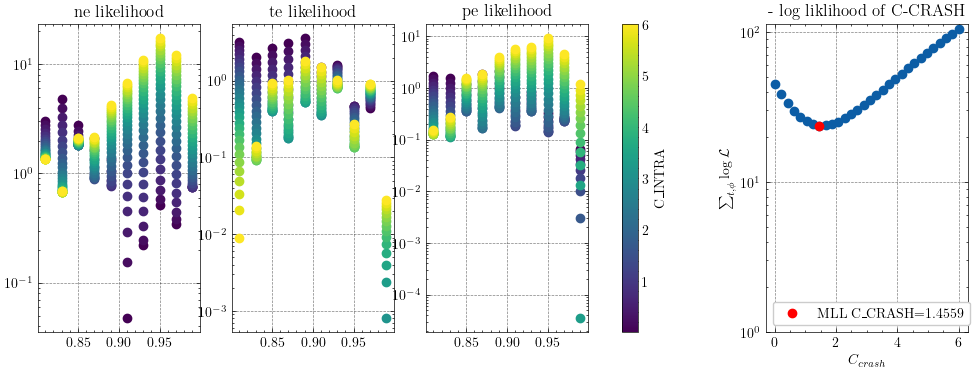

In [8]:
# Want to compare the end result of the intra-elm crash for various C_CRASH values with respect to the experimental data 
# this will entail radial windowing of the experimental data for time points near ELM crash. 
# EXP DATA: - t_minus_t_elm (less than 1 ms), - relevant_profiles.ne, relevant_profiles.te, computed pressure from te and ne
# SIM DATA: - t_idx-1, i.e., end of "intra elm" - solutions_intraelm_te, solutions_intraelm_ne, solutions_intraelm_pe, phi_norm
# ultimately, calculating the log likelihood of the C_CRASH values given the experimental data (normal distribution)

# Windows: [0.8, 0.85], [0.85, 0.9], [0.9, 0.95], [0.95, 1.0]
# Times: t_minus_t_elm < 1ms 

# windows = [(0.8, 0.85), (0.85, 0.9), (0.9, 0.95), (0.95, 1.0)]
spacing = 0.02
windows = [(x, x + spacing) for x in np.arange(0.8, 1.0, spacing)]


window_likelihoods = np.zeros((len(collected), 3, len(windows)))
for i, t in enumerate(t_minus_t_elm*1000):
    if t > 1.5 or t < 0.0: 
        continue 

    for k, window in enumerate(windows): 
        window_bool = np.logical_and(relevant_profiles.hrts_psi[i] + offset > window[0], relevant_profiles.hrts_psi[i] + offset < window[1])
        window_ne = relevant_profiles.ne[i, window_bool]*1E-19
        window_te = relevant_profiles.te[i, window_bool]/1000.0
        window_pe = calculate_pressure(window_te, window_ne)

        for c, collect in enumerate(collected): 
            C_INTRA, INTRA_PARAMS, solutions_intraelm_te, solutions_intraelm_ne, solutions_intraelm_pe = collect

            color = plt.cm.viridis((C_INTRA - min_c_crash) / (max_c_crash - min_c_crash))
            sim_window_bool = np.logical_and(phi_norm > window[0], phi_norm < window[1])
            sim_window_ne = solutions_intraelm_ne[sim_window_bool, -1]
            sim_window_te = solutions_intraelm_te[sim_window_bool, -1]
            sim_window_pe = solutions_intraelm_pe[sim_window_bool, -1]
            sim_window_ne_mean = np.mean(sim_window_ne)
            sim_window_te_mean = np.mean(sim_window_te)
            sim_window_pe_mean = np.mean(sim_window_pe)
            sim_window_ne_std = np.std(sim_window_ne)
            sim_window_te_std = np.std(sim_window_te)
            sim_window_pe_std = np.std(sim_window_pe)

            # likelihood calculation, eg., 
            log_liklihood = lambda x_i, mu, sigma: -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * (x_i - mu)**2 / sigma**2
            ne_likelihood = np.sum([log_liklihood(x_i, sim_window_ne_mean, sim_window_ne_std) for x_i in window_ne])
            te_likelihood = np.sum([log_liklihood(x_i, sim_window_te_mean, sim_window_te_std) for x_i in window_te])
            pe_likelihood = np.sum([log_liklihood(x_i, sim_window_pe_mean, sim_window_pe_std) for x_i in window_pe])
            # print(sim_window_ne_mean, window_ne.mean())

            # print(C_INTRA, ne_likelihood, te_likelihood, pe_likelihood)
            
            window_likelihoods[c, 0, k] += ne_likelihood
            window_likelihoods[c, 1, k] += te_likelihood
            window_likelihoods[c, 2, k] += pe_likelihood
            
        # print()
        
window_likelihoods /= len(t_minus_t_elm)

fig, axs= plt.subplots(1, 4, figsize=(12, 4)) 

for i, window in enumerate(windows): 
    x_pos = (window[1] + window[0]) / 2.0

    for c, collect in enumerate(collected):
        C_CRASH, *_ = collect
        color = plt.cm.viridis((C_CRASH - min_c_crash) / (max_c_crash - min_c_crash))

        axs[0].scatter(x_pos, -window_likelihoods[c, 0, i], color=color)
        axs[1].scatter(x_pos, -window_likelihoods[c, 1, i], color=color)
        axs[2].scatter(x_pos, -window_likelihoods[c, 2, i], color=color)

neg_sumover_windows_and_netepe = -np.sum(window_likelihoods, axis=(1, 2))

# Log scale 
axs[3].scatter(scan_crashes, neg_sumover_windows_and_netepe)
best_c_crash_idx = np.argmin(neg_sumover_windows_and_netepe)

axs[3].scatter(scan_crashes[best_c_crash_idx], neg_sumover_windows_and_netepe[best_c_crash_idx], color='red', label='MLL C_CRASH={:.4f}'.format(scan_crashes[best_c_crash_idx]))

axs[3].set_yscale('log')
axs[3].set_yticks([1, 10, 100])
axs[3].set_xlabel(r'$C_{crash}$')
axs[3].set_ylabel(r'$\sum_{t, \phi} \log \mathcal{L}$')
axs[3].set_title('- log liklihood of C-CRASH')
axs[3].legend()
fig.colorbar(ax=axs[:3], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_crash, vmax=max_c_crash)), label='C_INTRA')
axs[0].set_title('ne likelihood')
axs[1].set_title('te likelihood')
axs[2].set_title('pe likelihood')
for ax in axs[:3]: 
    ax.set_yscale('log')
    


In [8]:
# CHI0_INTRA = chi_gb[0]    
# D0_INTRA   = Dbohm[0]
# 
# C_CRASH =  scan_crashes[best_c_crash_idx] #  
# print(C_CRASH)
# intra_params = TransParams(
#         CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_CRASH, CHI0_INTRA*2.0), # np.ones_like(phi_norm),
#         D=normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_CRASH , D0_INTRA*5.0), # np.ones_like(phi_norm),
#         V=np.ones_like(phi_norm),
#         S_N=np.zeros_like(phi_norm),
#         S_T=np.zeros_like(phi_norm),
#         _C = C_CRASH,
#         ne_fitparams=ne_fit_params, 
#         te_fitparams=te_fit_params, 
#         bcs=BCS.INTRA_FIXED, 
#         dphi_normdr=dphi_normdr,
#         mps = machineparams
#     )
# 
# # intra_params.heatfluxin = phi_norm[0]*(intra_params.CHI[0]*C_CRASH*10)*np.gradient(steady_state_te, phi_norm)[0]
# # scale_factor = 0.6 + (1.0 - 0.8) * (1.0 - C_CRASH / max_c_crash)
# # intra_params.te_inner_lim = scale_factor*max(steady_state_te)
# intra_params.heatfluxin   = phi_norm[0]*(chi_gb[0])*np.gradient(steady_state_te, phi_norm)[0]
# intra_params.te_inner_lim = 0.0
# 
# intra_params.particlefluxin = (Dbohm[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
# intra_params.particlefluxout = (intra_params.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1]    
# intra_params.ne_inner_lim = 0.0 # max(steady_state_ne) * scale_factor # scale_factor # (1.0/(C_CRASH*2))
# intra_params.ne_outer_lim = 0.0 # steady_state_ne[-1] * scale_factor # (1.0/C_CRASH) # steady_state_ne[-1]*0.3
C_CRASH = 1.4559 # scan_crashes[best_c_crash_idx]
intra_params = setup_intra_params(C_CRASH, xdomain, te_fit_params, ne_fit_params, chi_gb[0], Dbohm[0])
# intra_params.particlefluxin = (15*C_CRASH*intra_params.D[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
# intra_params.particlefluxout = (20*intra_params.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1# ]

# intra_params.ne_inner_lim = max(steady_state_ne) * scale_factor # scale_factor # (1.0/(C_CRASH*2))
# scale_factor = 0.4 + (1.0 - 0.4) * (1.0 - C_CRASH / max_c_crash)
# intra_params.ne_outer_lim = steady_state_ne[-1] * scale_factor # (1.0/C_CRASH) # steady_state_ne[-1]*0.3

tau_intraelm = 200E-6 # 200 us
t_interval = [0, tau_intraelm]
t_keep     = np.linspace(0, tau_intraelm, 10)
solutions_intraelm_te = solve_pde(phi_norm, steady_state_te, t_interval, intra_params, T_model, t_keep)
solutions_intraelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, intra_params, n_model, t_keep)
solutions_intraelm_pe = calculate_pressure(solutions_intraelm_te, solutions_intraelm_ne)
post_elm_ne = solutions_intraelm_ne[:, -1]
post_elm_te = solutions_intraelm_te[:, -1]
post_elm_pe = solutions_intraelm_pe[:, -1]

In [16]:
CHI0_INTRA = chi_gb[0]    
D0_INTRA   = Dbohm[0]

C_CRASH = scan_crashes[best_c_crash_idx]
intra_params = TransParams(
        CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_CRASH, CHI0_INTRA*2.0), # np.ones_like(phi_norm),
        D=normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_CRASH , D0_INTRA*5.0), # np.ones_like(phi_norm),
        V=np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_CRASH,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INTRA_FIXED, 
        dphi_normdr=dphi_normdr
    )

# intra_params.heatfluxin = phi_norm[0]*(intra_params.CHI[0]*C_CRASH*10)*np.gradient(steady_state_te, phi_norm)[0]
# scale_factor = 0.6 + (1.0 - 0.8) * (1.0 - C_CRASH / max_c_crash)
# intra_params.te_inner_lim = scale_factor*max(steady_state_te)

intra_params.particlefluxin = (15*C_CRASH*intra_params.D[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
intra_params.particlefluxout = (20*intra_params.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1]

intra_params.ne_inner_lim = max(steady_state_ne) * scale_factor # scale_factor # (1.0/(C_CRASH*2))
scale_factor = 0.4 + (1.0 - 0.4) * (1.0 - C_CRASH / max_c_crash)
intra_params.ne_outer_lim = steady_state_ne[-1] * scale_factor # (1.0/C_CRASH) # steady_state_ne[-1]*0.3

tau_intraelm = 200E-6 # 200 us
t_interval = [0, tau_intraelm]
t_keep     = np.linspace(0, tau_intraelm, 10)
solutions_intraelm_te = solve_pde(phi_norm, steady_state_te, t_interval, intra_params, T_model, t_keep)
solutions_intraelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, intra_params, n_model, t_keep)
solutions_intraelm_pe = calculate_pressure(solutions_intraelm_te, solutions_intraelm_ne)
post_elm_ne = solutions_intraelm_ne[:, -1]
post_elm_te = solutions_intraelm_te[:, -1]
post_elm_pe = solutions_intraelm_pe[:, -1]

In [14]:
CHI0_INTRA = chi_gb[0]
D0_INTRA   = Dbohm[0]
C_CRASH    = 2.0

intra_params = TransParams(
        CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w, C_CRASH, CHI0_INTRA), # np.ones_like(phi_norm),
        # D=normal_distribution(phi_norm, ne_fit_params.p, ne_fit_params.w / 2.0, C_CRASH, D0_INTRA*10), # np.ones_like(phi_norm),
        D=normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, 2*ne_fit_params.w, C_CRASH, D0_INTRA), # np.ones_like(phi_norm),
        V=np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_CRASH,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INSIDE_FIXED, 
        dphi_normdr=dphi_normdr
)

intra_params.heatfluxin = phi_norm[0]*(CHI0_INTRA*5.0)*np.gradient(steady_state_te, phi_norm)[0]
intra_params.te_inner_lim = 0.9*max(steady_state_te)

intra_params.particlefluxin = (5*intra_params.D[-1]*C_CRASH)*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
intra_params.particlefluxout = (intra_params.D[-1]*C_CRASH)*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]

# intra_params.particlefluxin = (D0_INTRA*1000.0)*np.gradient(steady_state_ne, phi_norm)[0] + intra_params.V[0]*steady_state_ne[0]
# intra_params.particlefluxout = (intra_params.D[-1]*100)*np.gradient(steady_state_ne, phi_norm)[0] + intra_params.V[0]*steady_state_ne[0]

# intra_params.ne_inner_lim = 0.9*max(steady_state_ne)
# intra_params.ne_outer_lim = ne_fit_params.h1 * 0.5 # steady_state_ne[-1]*0.3

t_interval = [0, tau_intraelm]
t_keep     = np.linspace(0, tau_intraelm, 10)


solutions_intraelm_te = solve_pde(phi_norm, steady_state_te, t_interval, intra_params, T_model, t_keep)
solutions_intraelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, intra_params, n_model, t_keep)


post_elm_te = solutions_intraelm_te[:, -1]
post_elm_ne = solutions_intraelm_ne[:, -1]

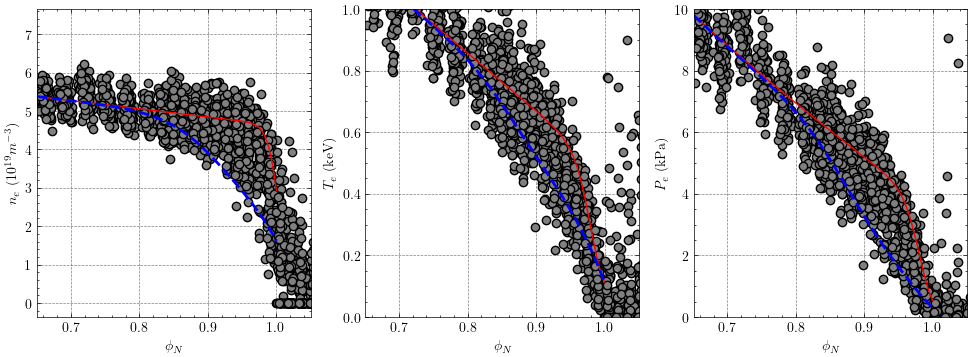

In [9]:
""" Plotting of crash """
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()

axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[0].plot(phi_norm, steady_state_ne, color='red')

axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[1].plot(phi_norm, steady_state_te, color='red')

axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[2].plot(phi_norm, steady_state_pe, color='red', label='JET PDB Fit')

axs[0].set_xlim(0.0, 7.5)
axs[1].set_ylim(0.0, 1)
axs[2].set_ylim(0, 10)
for ax in axs[:3]: 
    ax.set_xlim(phi_norm.min(), 1.05)
    ax.set_xlabel(r'$\phi_N$')
    
axs[0].set_ylabel(r'$n_e$ ($10^{19} m^{-3}$)')
axs[1].set_ylabel(r'$T_e$ (keV)')
axs[2].set_ylabel(r'$P_e$ (kPa)')

axs[0].plot(phi_norm, post_elm_ne, color='blue', lw=2, ls='--', label=f'Post ELM C_CRASH={C_CRASH:.2f}')
axs[1].plot(phi_norm, post_elm_te, color='blue', lw=2, ls='--', label=f'Post ELM C_CRASH={C_CRASH:.2f}')
axs[2].plot(phi_norm, post_elm_pe, color='blue', lw=2, ls='--', label=f'Post ELM C_CRASH={C_CRASH:.2f}')
# axs[1].plot(phi_norm, solutions_interelm_te[:, -1], color='green', lw=2, ls='--', label=f'Post Inter-ELM C_INTER={C_INTER:.2f}')

# axs[0].axhline(steady_state_ne[-1]*0.3)
plt.show()

In [38]:
CHI0_INTER = chi_gb[0]*0.50 # Factor 0.3 USED TO MATCH THE NE GROWTH, MORE OR LESS. 
D0_INTER   = Dbohm[0]*1.35

min_c_growth = 0.8
max_c_growth = 6.0
scan_c_growths = np.linspace(min_c_growth, max_c_growth, 20)
collected = []
total_time = 0.05

for C_GROWTH in tqdm(scan_c_growths):
    _, collection = unended_c_growth_run_from_postelm_crash(total_time, xdomain, C_GROWTH, post_elm_ne, post_elm_te, te_fit_params, ne_fit_params, CHI0_INTER, D0_INTER, machineparams, printout=False)
    solutions_interelm_times, solutions_interelm_te, solutions_interelm_ne, solutions_interelm_pe = collection 
    collect = (C_GROWTH, solutions_interelm_times, solutions_interelm_te, solutions_interelm_ne, solutions_interelm_pe)
    collected.append(collect)


  0%|          | 0/20 [00:00<?, ?it/s]

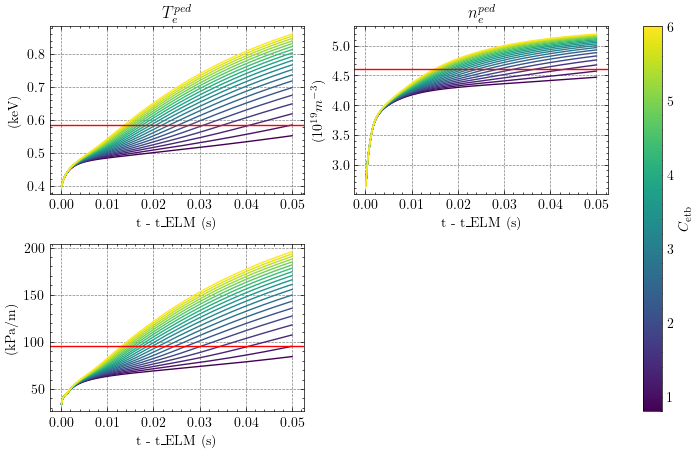

In [87]:
ped_idx_ne  = np.argmin(np.abs(phi_norm - (ne_fit_params.p - ne_fit_params.w)))
ped_idx_te  = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w)))
in_pedestal = xdomain.phi_norm > 0.94
alpha_crit = np.max(abs(np.gradient(steady_state_pe[in_pedestal], xdomain.phi_norm[in_pedestal])))

fig, axs = plt.subplots(2, 2, figsize=(9, 5))
axs = axs.ravel()

for collect in collected:
    C_GROWTH, solutions_interelm_times, solutions_interelm_te, solutions_interelm_ne, solutions_interelm_pe = collect
    # Plot the teped, neped, and maxpressuregrad in time on axs[0], axs[1], axs[2], at end remove axs[2]
    color = plt.cm.viridis((C_GROWTH - min_c_growth) / (max_c_growth - min_c_growth))

    axs[0].plot(solutions_interelm_times, solutions_interelm_te[:, ped_idx_te], color=color)
    axs[1].plot(solutions_interelm_times, solutions_interelm_ne[:, ped_idx_ne], color=color)
    axs[2].plot(solutions_interelm_times, np.max(abs(np.gradient(solutions_interelm_pe[:, in_pedestal], xdomain.phi_norm[in_pedestal], axis=1)), axis=1), color=color)

axs[0].set_title(r'$T_e^{ped}$')
axs[1].set_title(r'$n_e^{ped}$')
axs[0].set_ylabel(r'(keV)')
axs[1].set_ylabel(r'($10^{19} m^{-3}$)')
axs[2].set_ylabel(r'$\text{max} \nabla P^{\phi_{ped}}$')
axs[2].set_ylabel(r'(kPa/m)')
for ax in axs: 
    ax.set_xlabel(r't - t_{ELM} (s)')

axs[0].axhline(steady_state_te[ped_idx_te], color='red')
axs[1].axhline(steady_state_ne[ped_idx_ne], color='red')
axs[2].axhline(alpha_crit, color='red')

fig.subplots_adjust(hspace=0.3)

fig.colorbar(ax=axs, mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_growth, vmax=max_c_growth)), label=r'$C_\text{etb}$')
axs[3].remove()
savename = os.path.join(FIGURE_DIR, f'jet_{shot_num}_growth_sensitivity_scan.png')
plt.savefig(savename, dpi=500, transparent=True)
plt.show()

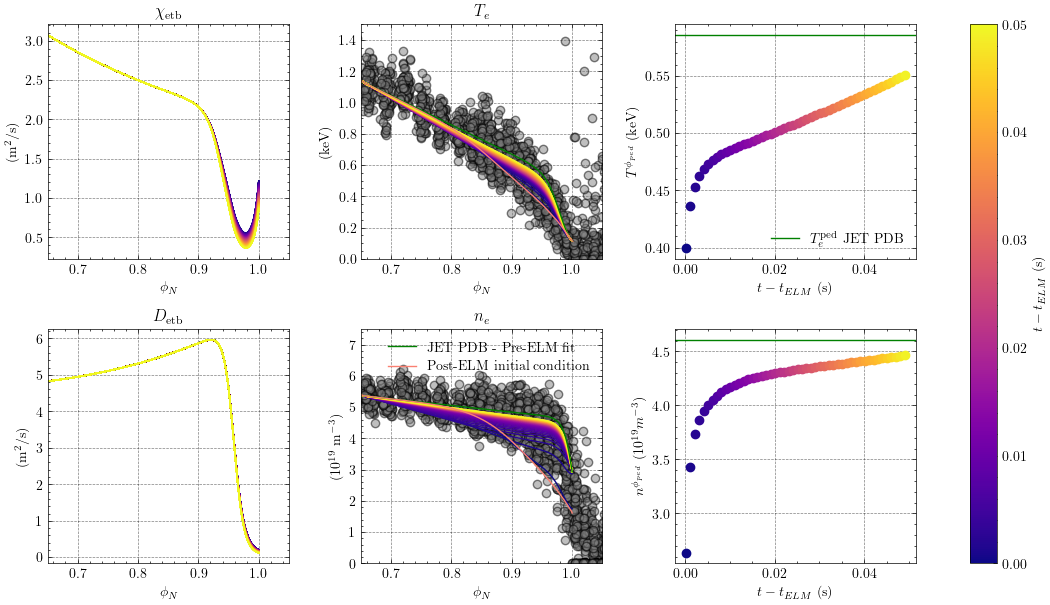

In [76]:

fig, axs = plt.subplots(2, 3, figsize=(14, 7))

axs = axs.ravel()
for collect in collected: 
    C_GROWTH, solutions_interelm_times, solutions_interelm_te, solutions_interelm_ne, solutions_interelm_pe = collect
    INTER_PARAMS = setup_inter_params(xdomain, te_fit_params, ne_fit_params, machineparams, CHI0_INTER, D0_INTER)
    # color = plt.cm.plasma((C_GROWTH - min_c_growth) / (max_c_growth - min_c_growth))
    
    for t in solutions_interelm_times: 
        color = plt.cm.plasma((t - solutions_interelm_times[0]) / (solutions_interelm_times[-1] - solutions_interelm_times[0]))

        INTER_PARAMS._C = get_c_inter_over_time(t, C_GROWTH)
        INTER_PARAMS.CHI = get_chi_inter(xdomain.phi_norm, CHI0_INTER, te_fit_params.steady_state_arr, INTER_PARAMS)
        INTER_PARAMS.D   = get_d_inter(xdomain.phi_norm, D0_INTER, ne_fit_params.steady_state_arr, INTER_PARAMS)

        axs[0].plot(xdomain.phi_norm, INTER_PARAMS.CHI, color=color)
        axs[3].plot(xdomain.phi_norm, INTER_PARAMS.D, color=color)
    # INTER_PARAMS._C = 0.05
    # INTER_PARAMS.CHI = get_chi_inter(xdomain.phi_norm, CHI0_INTER, te_fit_params.steady_state_arr, INTER_PARAMS)
    # INTER_PARAMS.D   = get_d_inter(xdomain.phi_norm, D0_INTER, ne_fit_params.steady_state_arr, INTER_PARAMS)
    # axs[0].plot(xdomain.phi_norm, INTER_PARAMS.CHI, color='grey')
    # axs[1].plot(xdomain.phi_norm, INTER_PARAMS.D, color='grey', label='\'Steady State\'')

    # Plot every 10 time slices from solutions 
    for i in range(0, len(solutions_interelm_times), 10): 
        color = plt.cm.plasma((solutions_interelm_times[i] - solutions_interelm_times[0]) / (solutions_interelm_times[-1] - solutions_interelm_times[0]))
        axs[1].plot(xdomain.phi_norm, solutions_interelm_te[i, :], color=color)
        axs[4].plot(xdomain.phi_norm, solutions_interelm_ne[i, :], color=color)
        axs[2].scatter(solutions_interelm_times[i], solutions_interelm_te[i, ped_idx_te], color=color)
        axs[5].scatter(solutions_interelm_times[i], solutions_interelm_ne[i, ped_idx_ne], color=color)

    maxpressgrad = np.max(abs(np.gradient(solutions_interelm_pe[:, in_pedestal], xdomain.phi_norm[in_pedestal], axis=1)), axis=1)

    # axs[2].plot(solutions_interelm_times + tau_intraelm, solutions_interelm_te[:, ped_idx_te], color=color)
    # axs[3].plot(solutions_interelm_times + tau_intraelm, solutions_interelm_ne[:, ped_idx_ne], color=color)
    # axs[5].plot(solutions_interelm_times + tau_intraelm, maxpressgrad, color=color)
    break 
axs[2].axhline(steady_state_te[ped_idx_te], color='green', label=r'$T_e^\text{ped}$ JET PDB')
axs[5].axhline(steady_state_ne[ped_idx_ne], color='green', label=r'$n_e^\text{ped}$ JET PDB')
# axs[5].axhline(alpha_crit, color='green', label=r'$\alpha_{crit}$ JET PDB - Pre-ELM fit')
# plot the hrts profiles on axs 2, 3, 

axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black', alpha=0.5)
axs[4].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black', alpha=0.5)

axs[0].set_title(r'$\chi_\text{etb}$')
axs[0].set_ylabel('(m$^2$/s)')
axs[3].set_title(r'$D_\text{etb}$')
axs[3].set_ylabel('(m$^2$/s)')
axs[1].set_title('$T_e$')
axs[1].set_ylabel('(keV)')
axs[4].set_title('$n_e$')
axs[4].set_ylabel('($10^{19}$ m$^{-3}$)')

axs[2].set_ylabel(r'$T^{\phi_{ped}}$ (keV)')
axs[5].set_ylabel(r'$n^{\phi_{ped}}$ ($10^{19} m^{-3}$)')
# axs[5].set_ylabel(r'$\text{max} \nabla P^{\phi_{ped}}$ (kPa/m)')
for ax in [axs[0], axs[1], axs[3], axs[4]]: 
    ax.set_xlim(phi_norm.min(), 1.05)
    ax.set_xlabel(r'$\phi_N$')
axs[1].set_ylim(0, 1.5)
axs[4].set_ylim(0, 7.5)
# t - t_{ELM} (ms) for axs[3], axs[4], axs[5]
# for ax in [axs[2], axs[3]]:# , axs[5]]: 
#     ax.set_xlabel('$t - t_{ELM}$ (ms)')
# colorbar 
axs[1].plot(xdomain.phi_norm, steady_state_te, color='green', label='JET PDB - Pre-ELM fit')
axs[4].plot(xdomain.phi_norm, steady_state_ne, color='green', label='JET PDB - Pre-ELM fit')

axs[1].plot(xdomain.phi_norm, post_elm_te, color='salmon')
axs[4].plot(xdomain.phi_norm, post_elm_ne, color='salmon', label='Post-ELM initial condition')
axs[4].legend(frameon=False)
axs[2].legend(frameon=False)
for ax in [axs[2], axs[5]]: 
    ax.set_xlabel('$t - t_{ELM}$ (s)')

fig.subplots_adjust(wspace=0.3, hspace=0.3)
# fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=min_c_growth, vmax=max_c_growth)), ax=axs, label=r'$C_\text{etb}$')
fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=total_time)), ax=axs, label=r'$t - t_{ELM}$ (s)')

fname = os.path.join(FIGURE_DIR, f'jet_{shot_num}_interelm_crash_sensitivity.png')
plt.savefig(fname, dpi=300, transparent=True)
plt.show()


In [11]:

total_time = 0.05
C_GROWTH = 2.053
_, collection = unended_c_growth_run_from_postelm_crash(total_time, xdomain, C_GROWTH, post_elm_ne, post_elm_te, te_fit_params, ne_fit_params, CHI0_INTER, D0_INTER, machineparams, printout=True)
solutions_interelm_times, solutions_interelm_te, solutions_interelm_ne, solutions_interelm_pe = collection 

Current Time: 0.0001, Alpha Exp: 36.87, Alpha Crit: 95.46, C_INTER: -0.05
Current Time: 0.0002, Alpha Exp: 53.22, Alpha Crit: 95.46, C_INTER: -0.0498
Current Time: 0.0003, Alpha Exp: 52.79, Alpha Crit: 95.46, C_INTER: -0.0496
Current Time: 0.0004, Alpha Exp: 51.73, Alpha Crit: 95.46, C_INTER: -0.0494
Current Time: 0.0005, Alpha Exp: 41.32, Alpha Crit: 95.46, C_INTER: -0.0492
Current Time: 0.0006, Alpha Exp: 71.51, Alpha Crit: 95.46, C_INTER: -0.049
Current Time: 0.0007, Alpha Exp: 42.63, Alpha Crit: 95.46, C_INTER: -0.0488
Current Time: 0.0008, Alpha Exp: 60.24, Alpha Crit: 95.46, C_INTER: -0.0486
Current Time: 0.0009, Alpha Exp: 43.69, Alpha Crit: 95.46, C_INTER: -0.0484
Current Time: 0.001, Alpha Exp: 71.77, Alpha Crit: 95.46, C_INTER: -0.0482
Current Time: 0.0011, Alpha Exp: 45.72, Alpha Crit: 95.46, C_INTER: -0.048
Current Time: 0.0012, Alpha Exp: 60.43, Alpha Crit: 95.46, C_INTER: -0.0478
Current Time: 0.0013, Alpha Exp: 45.4, Alpha Crit: 95.46, C_INTER: -0.0476
Current Time: 0.00

In [9]:
CHI0_INTER = chi_gb[0] / 2.0# /10.5
D0_INTER   = Dbohm[0]# /1.5

# ABOVE FACTORS CHOSEN TO HAVE AROUND 50MS ELM INTER-ELM time for steady state solution  (i.e., when C_INTER = 0.0)

max_c_inter = 0.1
min_c_inter = -0.05

scan_growths = np.linspace(min_c_inter, max_c_inter, 10)

tau_interelm = 0.05 # 
t_interval = [0, tau_interelm]
t_keep    = np.linspace(0, tau_interelm, 100)

collected_data = []

for C_INTER in tqdm(scan_growths):
    INTER_PARAMS = TransParams(
            CHI = np.empty_like(phi_norm),
            D   = np.empty_like(phi_norm),
            V   = phi_norm**5,
            S_N = np.zeros_like(phi_norm),
            S_T = np.zeros_like(phi_norm),
            _C  = C_INTER, 
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params,
            bcs=BCS.INTER_FLUXIN, 
            dphi_normdr=dphi_normdr, 
            mps=machineparams,
        )
    INTER_PARAMS.CHI = get_chi_inter(phi_norm, CHI0_INTER, steady_state_te, INTER_PARAMS)
    INTER_PARAMS.D = get_d_inter(phi_norm, D0_INTER, steady_state_ne, INTER_PARAMS)

    INTER_PARAMS.heatfluxin = -phi_norm[0]*(CHI0_INTER)*np.gradient(steady_state_te, phi_norm)[0]
    INTER_PARAMS.te_inner_lim = np.max(steady_state_te)

    INTER_PARAMS.particlefluxin  = -((D0_INTER)*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + INTER_PARAMS.V[0]*steady_state_ne[0])
    INTER_PARAMS.particlefluxout = -((D0_INTER)*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + INTER_PARAMS.V[-1]*steady_state_ne[-1])
    
    INTER_PARAMS.ne_inner_lim = np.max(steady_state_ne)
    INTER_PARAMS.ne_outer_lim = steady_state_ne[-1]

    solutions_interelm_te = solve_pde(phi_norm, post_elm_te, t_interval, INTER_PARAMS, T_model, t_keep)
    solutions_interelm_ne = solve_pde(phi_norm, post_elm_ne, t_interval, INTER_PARAMS, n_model, t_keep)
    
    collect = (C_INTER, INTER_PARAMS, solutions_interelm_te, solutions_interelm_ne)
    collected_data.append(collect)


  0%|          | 0/10 [00:00<?, ?it/s]

In [65]:
collected_data = []
CHI_INTER = chi_gb[0]/7.0
D_INTER   = Dbohm[0]/2.5
BASLINE_PARAMS = TransParams(
        CHI = np.empty_like(phi_norm),
        D   = np.empty_like(phi_norm),
        V   = phi_norm**5,
        S_N = np.zeros_like(phi_norm),
        S_T = np.zeros_like(phi_norm),
        _C  = 0.0, 
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params,
        bcs=BCS.INTER_FLUXIN, 
        dphi_normdr=dphi_normdr, 
        mps=machineparams,
    )
BASLINE_PARAMS.CHI = get_chi_inter_unscaled(phi_norm, (CHI_INTER), steady_state_te, BASLINE_PARAMS)
BASLINE_PARAMS.D = get_d_inter_unscaled(phi_norm, D_INTER, steady_state_ne, BASLINE_PARAMS)

BASLINE_PARAMS.heatfluxin = -phi_norm[0]*(CHI_INTER)*np.gradient(steady_state_te, phi_norm)[0]
BASLINE_PARAMS.te_inner_lim = np.max(steady_state_te)

BASLINE_PARAMS.particlefluxin  = -((D_INTER)*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + BASLINE_PARAMS.V[0]*steady_state_ne[0])
BASLINE_PARAMS.particlefluxout = -((D_INTER)*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + BASLINE_PARAMS.V[-1]*steady_state_ne[-1])

BASLINE_PARAMS.ne_inner_lim = np.max(steady_state_ne)
BASLINE_PARAMS.ne_outer_lim = steady_state_ne[-1]

solutions_interelm_te = solve_pde(phi_norm, post_elm_te, t_interval, BASLINE_PARAMS, T_model, t_keep)
solutions_interelm_ne = solve_pde(phi_norm, post_elm_ne, t_interval, BASLINE_PARAMS, n_model, t_keep)

collect = (-10.0, BASLINE_PARAMS, solutions_interelm_te, solutions_interelm_ne)
collected_data.append(collect)

In [42]:
max_c_inter = 6.0
min_c_inter = 1.0

tau_interelm = 0.05 # 
t_interval = [0, tau_interelm]
t_keep    = np.linspace(0, tau_interelm, 100)


collected_data = []
for C_INTER in np.linspace(min_c_inter, max_c_inter, 5):
    # C_INTER = 3.5
    INTER_PARAMS = TransParams(
            CHI = np.empty_like(phi_norm),
            D   = np.empty_like(phi_norm),
            V   = phi_norm**5,
            S_N = np.zeros_like(phi_norm),
            S_T = np.zeros_like(phi_norm),
            _C  = C_INTER, 
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params,
            bcs=BCS.INTER_FLUXIN, 
            dphi_normdr=dphi_normdr, 
            mps=machineparams,
        )

    INTER_PARAMS.CHI = get_chi_inter(phi_norm, (CHI0_INTRA/3.5)/C_INTER, steady_state_te, INTER_PARAMS)
    # INTER_PARAMS.heatfluxin = -phi_norm[0]*CHI0_INTRA*np.gradient(steady_state_te, phi_norm)[0]
    INTER_PARAMS.te_inner_lim = np.max(steady_state_te)
    INTER_PARAMS.heatfluxin = -phi_norm[0]*(chi_gb[0])*np.gradient(steady_state_te, phi_norm)[0]
    INTER_PARAMS.heatfluxin = -phi_norm[0]*(INTER_PARAMS.CHI[0])*np.gradient(steady_state_te, phi_norm)[0]


    INTER_PARAMS.D = get_d_inter(phi_norm, (D0_INTRA*3.0)/C_INTER, steady_state_ne, INTER_PARAMS)
    # INTER_PARAMS.particlefluxin = -5*D0_INTRA*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + INTER_PARAMS.V[0]*steady_state_ne[0]
    # INTER_PARAMS.particlefluxout = -D0_INTRA*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + INTER_PARAMS.V[-1]*steady_state_ne[-1]
    INTER_PARAMS.particlefluxin  = -(Dbohm[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + INTER_PARAMS.V[0]*steady_state_ne[0]
    INTER_PARAMS.particlefluxout = -(Dbohm[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1]
    INTER_PARAMS.particlefluxin  = -(INTER_PARAMS.D[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + INTER_PARAMS.V[0]*steady_state_ne[0]
    INTER_PARAMS.particlefluxout = -(INTER_PARAMS.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + INTER_PARAMS.V[-1]*steady_state_ne[-1]
    INTER_PARAMS.ne_inner_lim = np.max(steady_state_ne)
    INTER_PARAMS.ne_outer_lim = steady_state_ne[-1]

    solutions_interelm_te = solve_pde(phi_norm, post_elm_te, t_interval, INTER_PARAMS, T_model, t_keep)
    solutions_interelm_ne = solve_pde(phi_norm, post_elm_ne, t_interval, INTER_PARAMS, n_model, t_keep)
    
    collect = (C_INTER, INTER_PARAMS, solutions_interelm_te, solutions_interelm_ne)
    collected_data.append(collect)

KeyboardInterrupt: 

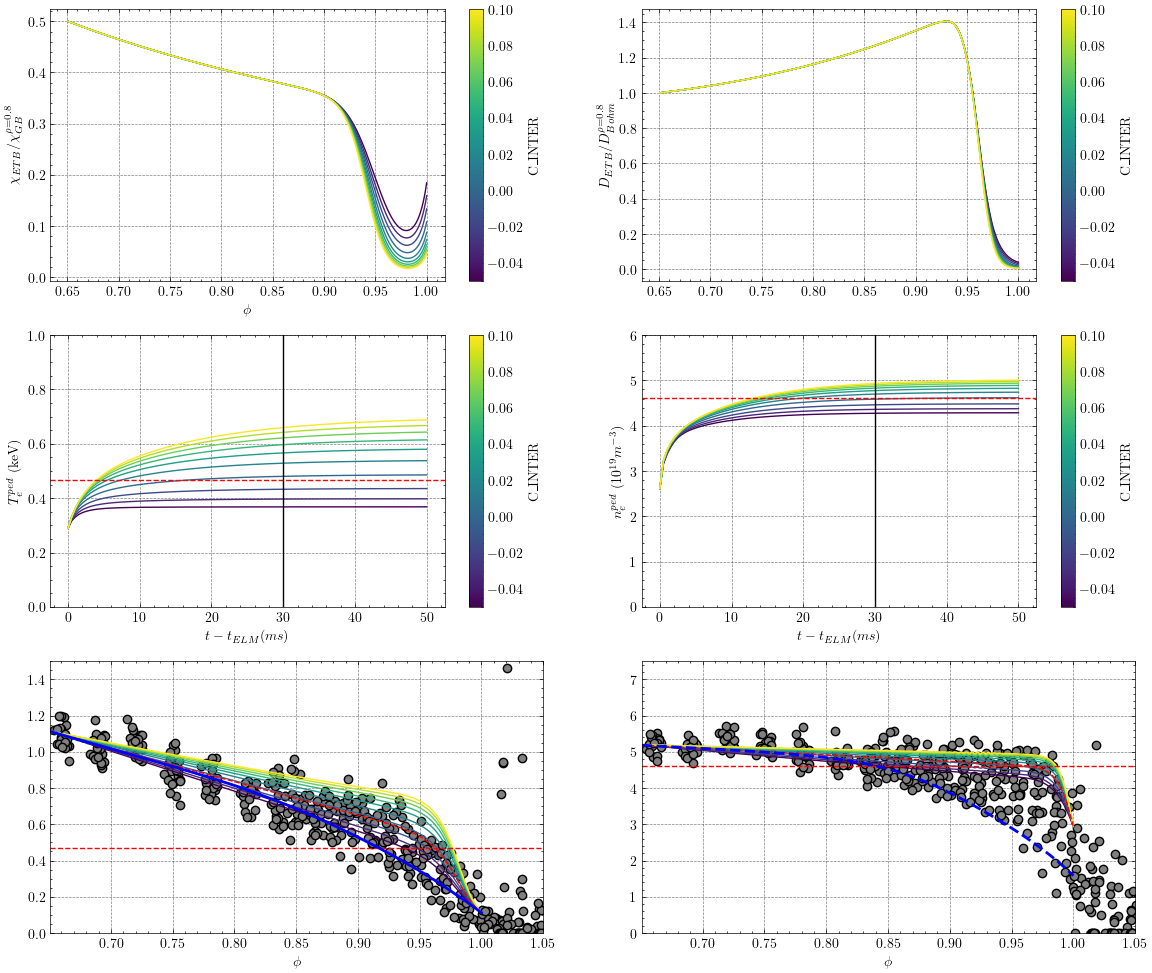

In [10]:
ped_idx_ne = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
ped_idx_te = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
t_interest = 0.03
t_interest_idx = np.argmin(np.abs(t_keep - t_interest))
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.ravel()
for collect in collected_data: 
    C_INTER, INTER_PARAMS, solutions_interelm_te, solutions_interelm_ne = collect
    color = plt.cm.viridis((C_INTER - min_c_inter) / (max_c_inter - min_c_inter)) # if C_INTER > 0 else 'pink'
    axs[0].plot(phi_norm, INTER_PARAMS.CHI / chi_gb[0], color=color)
    axs[2].plot(t_keep*1000.0 + tau_intraelm, solutions_interelm_te[ped_idx_te, :], color=color)
    axs[1].plot(phi_norm, INTER_PARAMS.D / Dbohm[0], color=color)
    axs[3].plot(t_keep*1000.0 + tau_intraelm, solutions_interelm_ne[ped_idx_ne, :], color=color)
    axs[5].plot(phi_norm, solutions_interelm_ne[:, t_interest_idx], color=color)
    axs[4].plot(phi_norm, solutions_interelm_te[:, t_interest_idx], color=color)
    # axs[3].plot(t_keep, solutions_interelm_ne[0, :], color=color, ls='--')
    # axs[3].plot(t_keep, solutions_interelm_ne[-1, :], color=color, ls='--')
    

fig.colorbar(ax=axs[0], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')
fig.colorbar(ax=axs[1], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')


fig.colorbar(ax=axs[2], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')
fig.colorbar(ax=axs[3], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')

axs[2].axhline(steady_state_te[ped_idx_te], color='red', ls='--')
axs[3].axhline(steady_state_ne[ped_idx_ne], color='red', ls='--')
axs[4].axhline(steady_state_te[ped_idx_te], color='red', ls='--')
axs[5].axhline(steady_state_ne[ped_idx_ne], color='red', ls='--')


axs[0].set_ylabel(r'$\chi_{ETB} /  \chi_{GB}^{\rho=0.8}$')
axs[1].set_ylabel(r'$D_{ETB} / D_{Bohm}^{\rho=0.8}$')

axs[0].set_xlabel(r'$\phi$')
# axs[0].axhline(chi_gb[0], color='black', label='$\chi_{GB}$')

axs[2].set_xlabel('$t - t_{ELM} (ms)$')
axs[3].set_xlabel('$t - t_{ELM} (ms)$')
axs[2].set_ylabel(r'$T_e^{ped}$ (keV)')
axs[3].set_ylabel(r'$n_e^{ped}$ ($10^{19} m^{-3}$)')


axs[5].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[5].plot(phi_norm, steady_state_ne, color='red', ls='--')
axs[5].plot(phi_norm, post_elm_ne, color='blue', lw=2, ls='--', label=f'Post ELM C_CRASH={C_CRASH:.2f}')

axs[4].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[4].plot(phi_norm, steady_state_te, color='red', ls='--')
axs[4].plot(phi_norm, post_elm_te, color='blue', lw=2)

axs[0].set_title
for ax in axs[4:]: 
    ax.set_xlim(np.min(phi_norm), 1.05)
    ax.set_xlabel(r'$\phi$')
for ax in [axs[2], axs[3]]: 
    ax.axvline(t_interest*1000.0, color='black')
axs[5].set_ylim(0.0, 7.5)
axs[4].set_ylim(0.0, 1.5)
axs[2].set_ylim(0.0, 1.0)
axs[3].set_ylim(0.0, 6.0)
# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='C_INTER')
plt.show()

KeyboardInterrupt: 

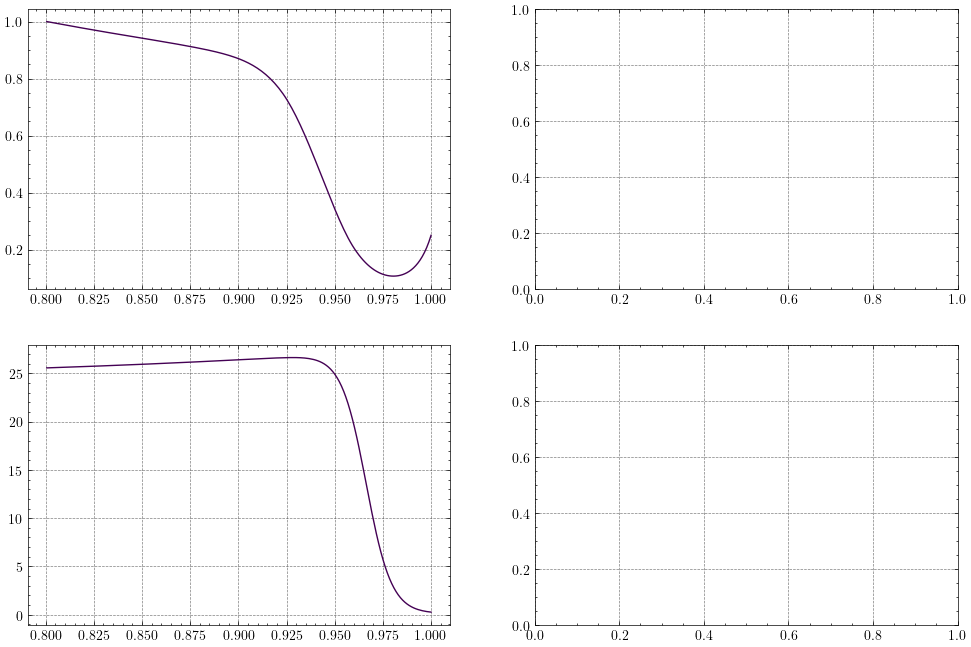

In [144]:


# Loop through various C_INTER 
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()
max_c_inter = 15.0
min_c_inter = 0.1

for C_INTER in np.linspace(min_c_inter, max_c_inter, 5):
    # C_INTER = 3.5
    INTER_PARAMS = TransParams(
            CHI = np.empty_like(phi_norm),
            D   = np.empty_like(phi_norm),
            V   = phi_norm**5,
            S_N = np.zeros_like(phi_norm),
            S_T = np.zeros_like(phi_norm),
            _C  = C_INTER, 
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params,
            bcs=BCS.INTER_FLUXIN
        )

    INTER_PARAMS.CHI = get_chi_inter(phi_norm, CHI0_INTRA/C_INTER, steady_state_te, INTER_PARAMS)
    INTER_PARAMS.heatfluxin = phi_norm[0]*INTER_PARAMS.CHI[0]*np.gradient(steady_state_te, phi_norm)[0]
    INTER_PARAMS.te_inner_lim = np.max(steady_state_te)

    INTER_PARAMS.D = get_d_inter(phi_norm, (D0_INTRA*100)/C_INTER, steady_state_ne, INTER_PARAMS)
    INTER_PARAMS.particlefluxin = -15*INTER_PARAMS.D[0]*np.gradient(steady_state_ne, phi_norm)[0] + INTER_PARAMS.V[0]*steady_state_ne[0]
    INTER_PARAMS.particlefluxout = -15*INTER_PARAMS.D[-1]*np.gradient(steady_state_ne, phi_norm)[-1] + INTER_PARAMS.V[-1]*steady_state_ne[-1]
    INTER_PARAMS.ne_inner_lim = np.max(steady_state_ne)
    INTER_PARAMS.ne_outer_lim = steady_state_ne[-1]

    # color = plt.cm.viridis((C_INTER - 1.0) / 15.0)
    color = plt.cm.viridis((C_INTER - min_c_inter) / (max_c_inter - min_c_inter))
    axs[0].plot(phi_norm, INTER_PARAMS.CHI / chi_gb[0], color=color)
    axs[2].plot(phi_norm, INTER_PARAMS.D, color=color)

    tau_interelm = 0.1 # 
    t_interval = [0, tau_interelm]
    t_keep    = np.linspace(0, tau_interelm, 100)
    ped_idx = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
    solutions_interelm_te = solve_pde(phi_norm, post_elm_te, t_interval, INTER_PARAMS, T_model, t_keep)
    solutions_interelm_ne = solve_pde(phi_norm, post_elm_ne, t_interval, INTER_PARAMS, n_model, t_keep)
    
    axs[1].plot(t_keep, solutions_interelm_te[ped_idx, :], label=f'C_INTER={C_INTER:.3}', color=color)
    axs[3].plot(t_keep, solutions_interelm_ne[ped_idx, :], label=f'C_INTER={C_INTER:.3}', color=color)

    # axs[3].plot(t_keep, solutions_interelm_ne[-1, :], ls='--', color=color)
    # axs[3].plot(t_keep, solutions_interelm_ne[0, :], ls=':', color=color)
    # plot_interelm_evolution(solutions_interelm_te, t_keep, phi_norm, title=f'C_CRASH={C_CRASH:.3}, C_INTER={C_INTER:.3}')

fig.colorbar(ax=axs[0], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')
fig.colorbar(ax=axs[1], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')


fig.colorbar(ax=axs[2], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')
fig.colorbar(ax=axs[3], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')

axs[1].axhline(steady_state_te[ped_idx], color='red')
axs[3].axhline(steady_state_ne[ped_idx], color='red')

axs[0].set_ylabel(r'$\chi_{ETB} /  \chi_{GB}^{\rho=0.8}$')
axs[0].set_xlabel(r'$\phi$')
# axs[0].axhline(chi_gb[0], color='black', label='$\chi_{GB}$')

axs[1].set_xlim(0.0, 0.05)
axs[0].legend(frameon=False)
axs[1].set_xlabel('$t - t_{ELM} (s)$')
axs[3].set_xlabel('$t - t_{ELM} (s)$')
axs[1].set_ylabel(r'$T_e^{ped}$ (keV)')
axs[3].set_ylabel(r'$n_e^{ped}$ ($10^{19} m^{-3}$)')

# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='C_INTER')
plt.show()

KeyboardInterrupt: 

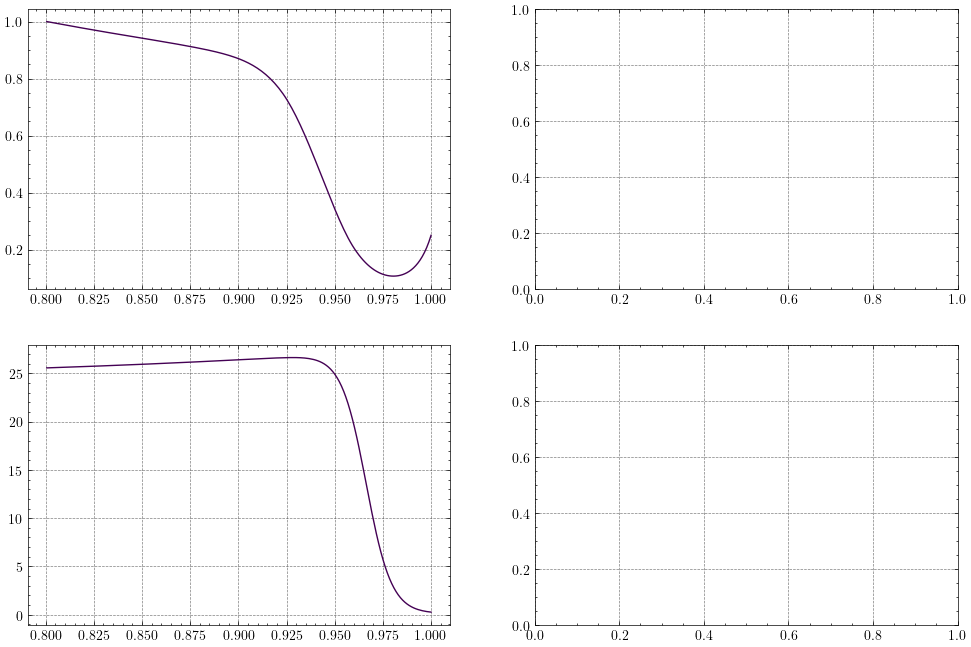

In [ ]:


# Loop through various C_INTER 
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()
max_c_inter = 15.0
min_c_inter = 1.0

for C_INTER in np.linspace(min_c_inter, max_c_inter, 5):
    # C_INTER = 3.5
    INTER_PARAMS = TransParams(
            CHI = np.empty_like(phi_norm),
            D   = np.empty_like(phi_norm),
            V   = phi_norm**5,
            S_N = np.zeros_like(phi_norm),
            S_T = np.zeros_like(phi_norm),
            _C  = C_INTER, 
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params,
            bcs=BCS.INTER_FLUXIN
        )

    INTER_PARAMS.CHI = get_chi_inter(phi_norm, CHI0_INTRA/C_INTER, steady_state_te, INTER_PARAMS)
    INTER_PARAMS.heatfluxin = phi_norm[0]*INTER_PARAMS.CHI[0]*np.gradient(steady_state_te, phi_norm)[0]
    INTER_PARAMS.te_inner_lim = np.max(steady_state_te)

    INTER_PARAMS.D = get_d_inter(phi_norm, (D0_INTRA*100)/C_INTER, steady_state_ne, INTER_PARAMS)
    INTER_PARAMS.particlefluxin = -15*INTER_PARAMS.D[0]*np.gradient(steady_state_ne, phi_norm)[0] + INTER_PARAMS.V[0]*steady_state_ne[0]
    INTER_PARAMS.particlefluxout = -15*INTER_PARAMS.D[-1]*np.gradient(steady_state_ne, phi_norm)[-1] + INTER_PARAMS.V[-1]*steady_state_ne[-1]
    INTER_PARAMS.ne_inner_lim = np.max(steady_state_ne)
    INTER_PARAMS.ne_outer_lim = steady_state_ne[-1]

    # color = plt.cm.viridis((C_INTER - 1.0) / 15.0)
    color = plt.cm.viridis((C_INTER - min_c_inter) / (max_c_inter - min_c_inter))
    axs[0].plot(phi_norm, INTER_PARAMS.CHI / chi_gb[0], color=color)
    axs[2].plot(phi_norm, INTER_PARAMS.D, color=color)

    tau_interelm = 0.1 # 
    t_interval = [0, tau_interelm]
    t_keep    = np.linspace(0, tau_interelm, 100)
    ped_idx = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
    solutions_interelm_te = solve_pde(phi_norm, post_elm_te, t_interval, INTER_PARAMS, T_model, t_keep)
    solutions_interelm_ne = solve_pde(phi_norm, post_elm_ne, t_interval, INTER_PARAMS, n_model, t_keep)
    
    axs[1].plot(t_keep, solutions_interelm_te[ped_idx, :], label=f'C_INTER={C_INTER:.3}', color=color)
    axs[3].plot(t_keep, solutions_interelm_ne[ped_idx, :], label=f'C_INTER={C_INTER:.3}', color=color)

    # axs[3].plot(t_keep, solutions_interelm_ne[-1, :], ls='--', color=color)
    # axs[3].plot(t_keep, solutions_interelm_ne[0, :], ls=':', color=color)
    # plot_interelm_evolution(solutions_interelm_te, t_keep, phi_norm, title=f'C_CRASH={C_CRASH:.3}, C_INTER={C_INTER:.3}')

fig.colorbar(ax=axs[0], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')
fig.colorbar(ax=axs[1], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')


fig.colorbar(ax=axs[2], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')
fig.colorbar(ax=axs[3], mappable=plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), label='C_INTER')

axs[1].axhline(steady_state_te[ped_idx], color='red')
axs[3].axhline(steady_state_ne[ped_idx], color='red')

axs[0].set_ylabel(r'$\chi_{ETB} /  \chi_{GB}^{\rho=0.8}$')
axs[0].set_xlabel(r'$\phi$')
# axs[0].axhline(chi_gb[0], color='black', label='$\chi_{GB}$')

axs[1].set_xlim(0.0, 0.05)
axs[0].legend(frameon=False)
axs[1].set_xlabel('$t - t_{ELM} (s)$')
axs[3].set_xlabel('$t - t_{ELM} (s)$')
axs[1].set_ylabel(r'$T_e^{ped}$ (keV)')
axs[3].set_ylabel(r'$n_e^{ped}$ ($10^{19} m^{-3}$)')

# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='C_INTER')
plt.show()

In [8]:
CHI0 = chi_gb[0]
C_CRASH    = 3.5
D0_INTRA   = 25.0

INTRA_PARAMS = TransParams(
    CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w, C_CRASH, CHI0), # np.ones_like(phi_norm),
    D=normal_distribution(phi_norm, ne_fit_params.p, ne_fit_params.w / 2.0, C_CRASH, D0_INTRA), # np.ones_like(phi_norm),
    V=np.ones_like(phi_norm),
    S_N=np.zeros_like(phi_norm),
    S_T=np.zeros_like(phi_norm),
    _C = C_CRASH,
    ne_fitparams=ne_fit_params, 
    te_fitparams=te_fit_params, 
    bcs=BCS.INTRA_FLUXIN
)


C_INTER = 10.0
INTER_PARAMS = TransParams(
        CHI = np.empty_like(phi_norm),
        D   = np.empty_like(phi_norm),
        V   = phi_norm**5,
        S_N = np.zeros_like(phi_norm),
        S_T = np.zeros_like(phi_norm),
        _C  = C_INTER,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params,
        bcs=BCS.INTER_FLUXIN
    )

INTER_PARAMS.CHI = get_chi_inter(phi_norm, CHI0/C_INTER, steady_state_te, INTER_PARAMS)
INTER_PARAMS.fluxin = phi_norm[0]*INTER_PARAMS.CHI[0]*np.gradient(steady_state_te, phi_norm)[0]
INTER_PARAMS.te_inner_lim = np.max(steady_state_te)

INTRA_PARAMS.fluxin = phi_norm[0]*(CHI0*5.0)*np.gradient(steady_state_te, phi_norm)[0]
INTRA_PARAMS.te_inner_lim = 0.9*max(steady_state_te)


In [9]:
def plot_interelm_evolution(solutions: np.ndarray, time_kept: np.ndarray, phi: np.ndarray, title: str = ''): 
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(121, projection='3d')
    for idx in range(0, len(time_kept)): 
        ax.plot(phi, np.ones_like(phi)*time_kept[idx], solutions[:, idx], color='black')

    # change color of grid lines to be grey 
    # ax.xaxis._axinfo['grid'].update(color = 'grey', linestyle = '--')
    ax.yaxis._axinfo['grid'].update(color = 'white', linestyle = '--')

    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set max 5 major ticks for x-axis
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Set max 5 major ticks for y-axis
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))  # Set max 5 major ticks for z-axis

    # If you want to reduce minor ticks as well, you can set a specific interval for them:
    ax.xaxis.set_minor_locator(plt.MaxNLocator(5))  # Fewer minor ticks for x-axis
    ax.yaxis.set_minor_locator(plt.MaxNLocator(5))  # Fewer minor ticks for y-axis
    ax.zaxis.set_minor_locator(plt.MaxNLocator(5))  # Fewer minor ticks for z-axis

    ax1 = fig.add_subplot(122)

    for phi_idx in [0, len(phi)//2, len(phi)//2 + len(phi) // 4, -1]: 
        ax1.plot(time_kept, solutions[phi_idx, :], label=f'$\phi = {phi[phi_idx]:.2f}$')

    ax1.legend()
    ax.set_title(title)
    plt.show()
